In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import scipy
import statsmodels.stats.multitest as multiple

data_folder = './MovieSummaries/'

plot = pd.read_csv(data_folder+'plot_summaries.txt', sep='	', header=None, names=["wiki_id", "summary"])
movie_meta = pd.read_csv(data_folder+'movie.metadata.tsv', sep='	', header=None, names=["wiki_id", "freebase_id", "movie_name", "release_date", "revenue", "runtime", "languages", "coutries", "genres"])
char_meta = pd.read_csv(data_folder+'character.metadata.tsv', sep='	', header=None, names=["wiki_id", "freebase_id", "release_date", "character_name", "birth", "gender", "height", "ethnicity", "actor_name", "actor_age", "character_actor_map", "character_id", "actor_id"])
#tvtropes_clusters = pd.read_csv(data_folder+'tvtropes.clusters.txt')
#name_clusters = pd.read_csv(data_folder+'name.clusters.txt')
df = plot.merge(movie_meta, on="wiki_id", how='right')
df["languages"] = df.apply(lambda x: list(eval(x["languages"]).values()), axis=1)
df["coutries"] = df.apply(lambda x: list(eval(x["coutries"]).values()), axis=1)
df["genres"] = df.apply(lambda x: list(eval(x["genres"]).values()), axis=1)

In [50]:
import datetime

df.summary = df.summary.fillna('')
df.loc[df['wiki_id']== 29666067, 'release_date'] = datetime.datetime(2010, 12, 2)
dates = pd.to_datetime(df['release_date'])
df['release_date'] = dates

In [37]:
def plot_proportion(proportion,title):
    proportion.plot.bar(rot=45, figsize=(10, 6))
    plt.locator_params(nbins=20)
    plt.title(title)
    return proportion

In [38]:
def create_proportion_by_year(number_of_films):
    tot_by_year = df.groupby(df.release_date.dt.year)['wiki_id'].count()
    number_of_films_by_year = number_of_films.groupby(number_of_films.release_date.dt.year)['wiki_id'].count()
    number_of_films_by_year = number_of_films_by_year/tot_by_year
    return number_of_films_by_year.apply(lambda x: 0 if np.isnan(x) else x)

In [39]:
def proportion_of_movies_with_war_in_summary(df, title):
    pd.options.mode.chained_assignment = None
    war_movies = df[df.summary.str.lower().str.contains('war')]
    proportion_summary = create_proportion_by_year(war_movies)
    return plot_proportion(proportion_summary, title)

In [40]:
def proportion_of_nazis_in_summary(df, title):
    pd.options.mode.chained_assignment = None
    movies_with_nazis = df[df.summary.str.lower().str.contains('nazi')]
    nazis_by_year = create_proportion_by_year(movies_with_nazis)
    return plot_proportion(nazis_by_year, title)

In [41]:
def proportion_of_war_movies(df, title):
    war_movies_genre = df[df.genres.apply(lambda x :'War film' in x)]
    proportion_genre = create_proportion_by_year(war_movies_genre)
    return plot_proportion(proportion_genre, title)

In [42]:
def proportion_of_anti_war_movies(df, title):
    anti_war_movies_genre = df[df.genres.apply(lambda x :'Anti-war' in x)]
    proportion_anti_genre = create_proportion_by_year(anti_war_movies_genre)
    return plot_proportion(proportion_anti_genre, title)

In [43]:
def p_value_for_diff_years(war_movies, ind, WWII_ind):
    WWII=war_movies.loc[(war_movies.index <= WWII_ind[1]) & (war_movies.index >= WWII_ind[0])]
    p_values = []
    for lower, upper in ind:
        other = war_movies.loc[(war_movies.index <= upper) & (war_movies.index >= lower)]
        stat, p_value = scipy.stats.ttest_ind(WWII, other)
        p_values.append(p_value)
    return p_values

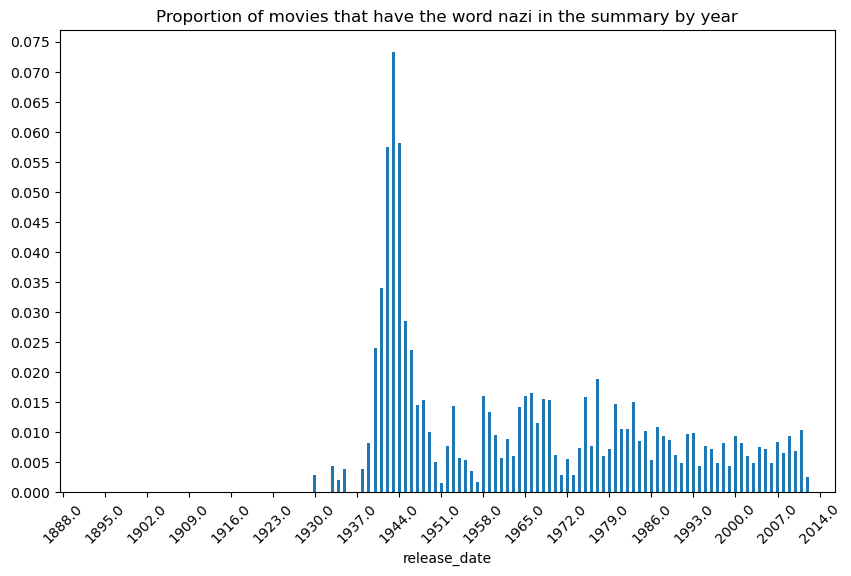

In [44]:
nazis_in_summaries=proportion_of_nazis_in_summary(df, "Proportion of movies that have the word nazi in the summary by year")

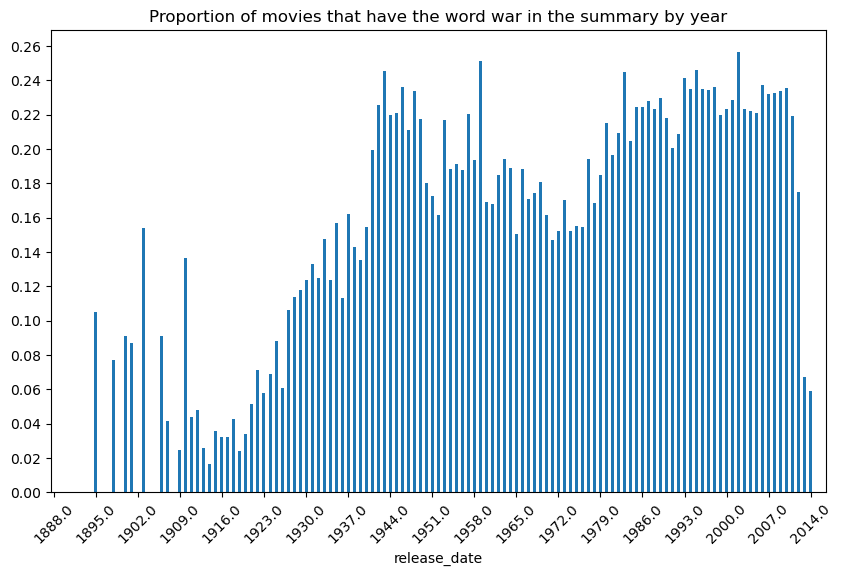

In [45]:
war_movies_by_year_summary=proportion_of_movies_with_war_in_summary(df, "Proportion of movies that have the word war in the summary by year")

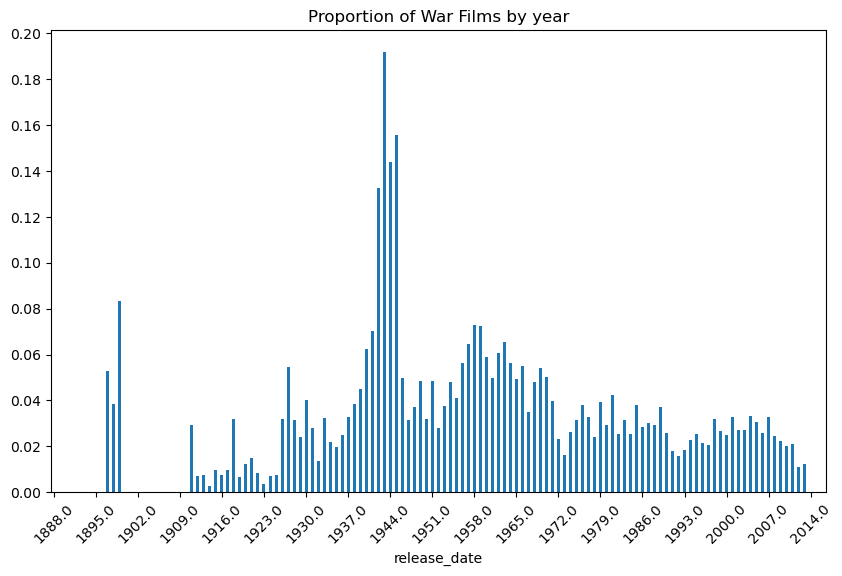

In [46]:
war_movies_by_year = proportion_of_war_movies(df, "Proportion of War Films by year")

In [47]:
WWII_ind = (1939,1945)
import numpy as np

In [51]:
#We're gonna compare the difference of movie production of movies made during 1939 and 1945 and movies made at other times
#We're gonna calulate the p-values of movies with the word 'war' in them, or movies with the word 'nazi' in them and
#finally just war movies in general
a =np.arange(1918, 2000, 7)
b = np.arange(1924, 2007, 7)
indexes = list(zip(a,b))
p_values_genres = p_value_for_diff_years(war_movies_by_year, indexes, WWII_ind)
p_values_summaries = p_value_for_diff_years(war_movies_by_year_summary, indexes, WWII_ind)
p_values_nazis = p_value_for_diff_years(nazis_in_summaries, indexes, WWII_ind)

7
7
7


In [52]:
multi_genres = multiple.multipletests(p_values_genres)
multi_summaries = multiple.multipletests(p_values_summaries)
multi_nazis = multiple.multipletests(p_values_nazis)

C:\Users\basti\anaconda3\envs\ada\lib\site-packages\statsmodels\stats\multitest.py:177: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))


In [53]:
multi_summaries

(array([ True,  True,  True, False, False, False, False, False, False,
        False, False, False]),
 array([1.29408293e-05, 2.20886646e-03, 3.21182142e-02, 1.00000000e+00,
        9.94926623e-01, 9.74815149e-01, 7.46913311e-01, 3.61129771e-01,
        7.46913311e-01, 7.46913311e-01, 7.46913311e-01, 4.13588830e-01]),
 0.004265318777560645,
 0.004166666666666667)

In [60]:
multi_genres

(array([ True,  True,  True, False,  True, False, False,  True,  True,
         True,  True,  True]),
 array([0.00498761, 0.01565773, 0.01213519, 1.        , 0.02008493,
        0.05086072, 0.05086072, 0.02008493, 0.01565773, 0.01565773,
        0.01152255, 0.01213519]),
 0.004265318777560645,
 0.004166666666666667)

In [71]:
multi_nazis[0]

array([ True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True])

We can see that for a surface search on the summaries we can't find a statistically significant difference between the movies made during the world war two and after. But we can find a statistical difference between movies made during World War II as there are significantly more War Movies made during World War II (it isn't statistically significant if we take a threshold at 0.05, but if we take a threshold slightly higher like 0.06, then it is statistically significant. So we can say that it is mostly significant). Also the word Nazi is used significantly more in plots during the world war, which makes sense considering the context, although we might need to look if the movies are made in the US or in Germany, this might have a different meaning.

In [62]:
usDf = df[df.coutries.apply(lambda x :'United States of America' in x)]
germanyDf = df[df.coutries.apply(lambda x :'Germany' in x)]

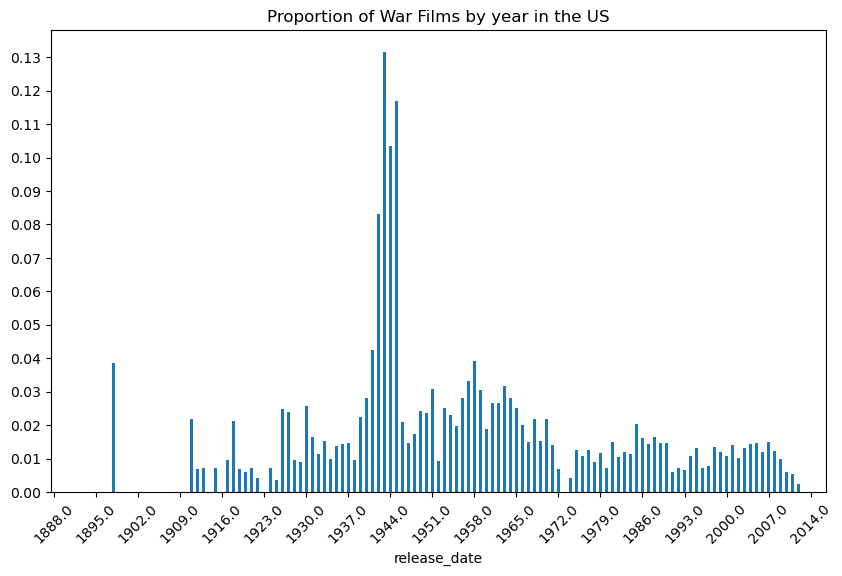

In [63]:
prop_war_films = proportion_of_war_movies(usDf, "Proportion of War Films by year in the US")

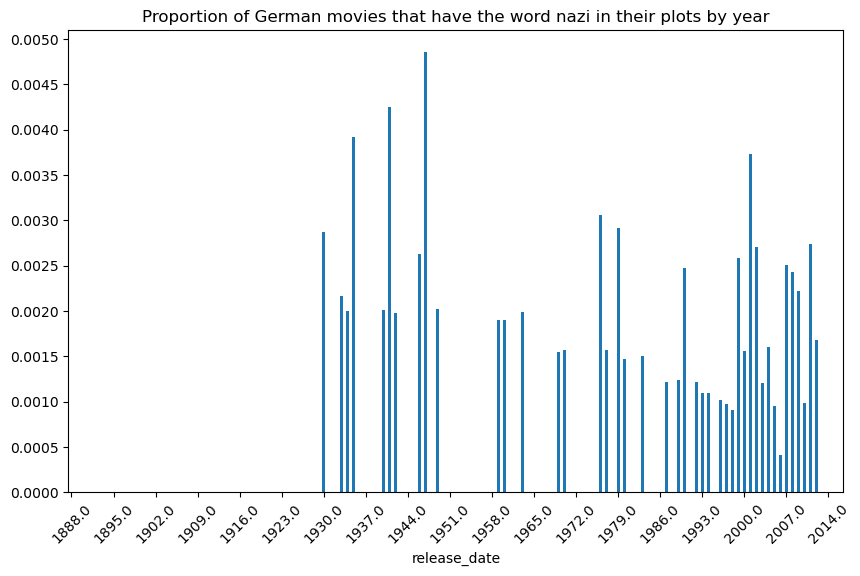

In [64]:
german_Nazi_movies = proportion_of_nazis_in_summary(germanyDf, "Proportion of German movies that have the word nazi in their plots by year")

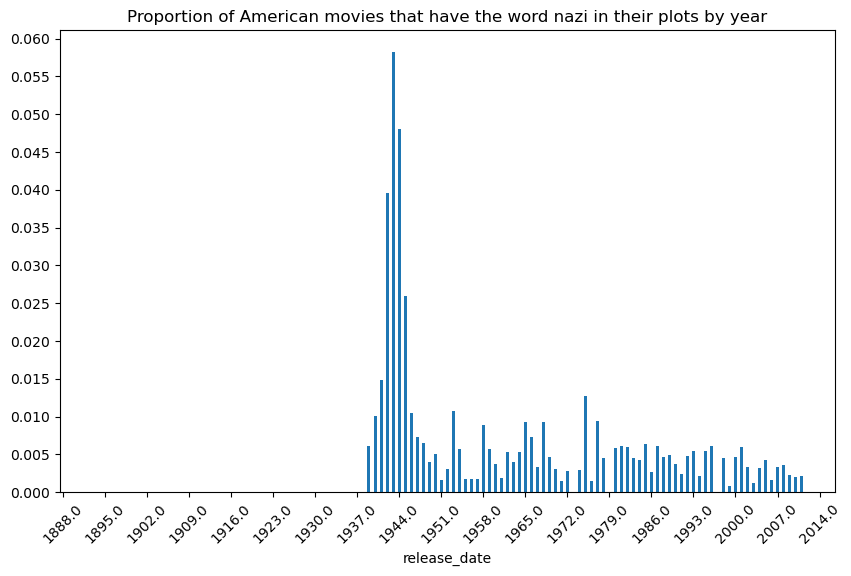

In [65]:
american_Nazi_movies = proportion_of_nazis_in_summary(usDf, "Proportion of American movies that have the word nazi in their plots by year")

In [66]:
multiple.multipletests(p_value_for_diff_years(american_Nazi_movies, indexes, WWII_ind), alpha=0.06)

C:\Users\basti\anaconda3\envs\ada\lib\site-packages\statsmodels\stats\multitest.py:177: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))


(array([ True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True]),
 array([0.02883675, 0.02883675, 0.02883675, 1.        , 0.05348677,
        0.05348677, 0.05348677, 0.05348677, 0.05348677, 0.05348677,
        0.05348677, 0.05348677]),
 0.005143012831822946,
 0.005)

In [67]:
multiple.multipletests(p_value_for_diff_years(german_Nazi_movies, indexes, WWII_ind), alpha=0.06)

(array([False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([0.64819114, 0.9630491 , 0.99982173, 1.        , 0.99982173,
        0.92327007, 0.97321093, 0.9630491 , 0.99982173, 0.95293394,
        0.99982173, 0.99812512]),
 0.005143012831822946,
 0.005)

We can see that the difference of plots that use the word Nazi in American movies during world war II is significant, but not for movies made in Germany. This doesn't make sense considering the context of the time, but might make sens considering the bias of the data that mostly contains american movies. Although we might notice also that German movies contain in proportion way more movies with Nazis in them and that they appear in 1930 whereas in American movies they first appear in 1939. We should increase the size of German movies during and after World War II in the dataset to continue this analysis.

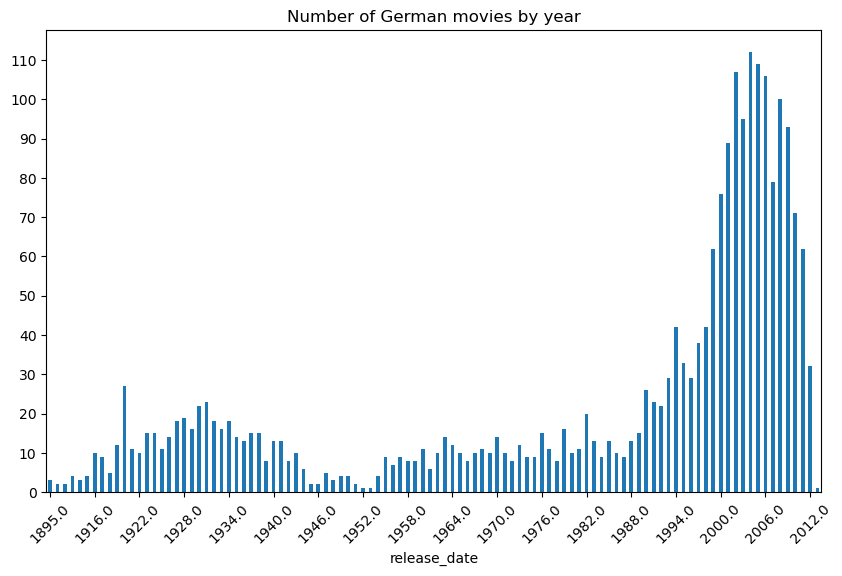

In [68]:
number_of_German_movies =plot_proportion(germanyDf.groupby(germanyDf.release_date.dt.year)['wiki_id'].count(), 'Number of German movies by year')

In [1]:
import pandas as pd
import spacy
import networkx as nx                        # a really useful network analysis library
import matplotlib.pyplot as plt
# from networkx.algorithms import community   # not used, yet... 
import datetime                              # access to %%time, for timing individual notebook cells
import os

data_folder = './MovieSummaries/'

plot = pd.read_csv(data_folder+'plot_summaries.txt', sep='	', header=None, names=["wiki_id", "summary"])
movie_meta = pd.read_csv(data_folder+'movie.metadata.tsv', sep='	', header=None, names=["wiki_id", "freebase_id", "movie_name", "release_date", "revenue", "runtime", "languages", "coutries", "genres"])
char_meta = pd.read_csv(data_folder+'character.metadata.tsv', sep='	', header=None, names=["wiki_id", "freebase_id", "release_date", "character_name", "birth", "gender", "height", "ethnicity", "actor_name", "actor_age", "character_actor_map", "character_id", "actor_id"])
#tvtropes_clusters = pd.read_csv(data_folder+'tvtropes.clusters.txt')
#name_clusters = pd.read_csv(data_folder+'name.clusters.txt')
df = plot.merge(movie_meta, on="wiki_id", how='right')
df["languages"] = df.apply(lambda x: list(eval(x["languages"]).values()), axis=1)
df["coutries"] = df.apply(lambda x: list(eval(x["coutries"]).values()), axis=1)
df["genres"] = df.apply(lambda x: list(eval(x["genres"]).values()), axis=1)

In [2]:
import datetime

df.summary = df.summary.fillna('')
df.loc[df['wiki_id']== 29666067, 'release_date'] = datetime.datetime(2010, 12, 2)
dates = pd.to_datetime(df['release_date'])
df['release_date'] = dates

In [3]:
plt.rcParams['figure.figsize'] = [10, 10]  # makes the output plots large enough to be useful

In [4]:
import en_core_web_lg

nlp = en_core_web_lg.load()

In [5]:
df.head()

,wiki_id,summary,freebase_id,movie_name,release_date,revenue,runtime,languages,coutries,genres
0,975900,"Set in the second half of the 22nd century, th...",/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,9363483,A series of murders of rich young women throug...,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,"Eva, an upper class housewife, becomes frustra...",/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,[German Language],[Germany],[Drama]


In [68]:
def draw_graph3(networkx_graph,notebook=True,output_filename='graph.html',show_buttons=True,only_physics_buttons=False):
    """
    This function accepts a networkx graph object,
    converts it to a pyvis network object preserving its node and edge attributes,
    and both returns and saves a dynamic network visualization.
    
    Valid node attributes include:
        "size", "value", "title", "x", "y", "label", "color".
        
        (For more info: https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.network.Network.add_node)
        
    Valid edge attributes include:
        "arrowStrikethrough", "hidden", "physics", "title", "value", "width"
        
        (For more info: https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.network.Network.add_edge)
        
    
    Args:
        networkx_graph: The graph to convert and display
        notebook: Display in Jupyter?
        output_filename: Where to save the converted network
        show_buttons: Show buttons in saved version of network?
        only_physics_buttons: Show only buttons controlling physics of network?
    """
    
    # import
    from pyvis import network as net
    
    # make a pyvis network
    pyvis_graph = net.Network(notebook=notebook)
    
    # for each node and its attributes in the networkx graph
    for node,node_attrs in networkx_graph.nodes(data=True):
        pyvis_graph.add_node(str(node),**node_attrs)
        
    # for each edge and its attributes in the networkx graph
    for source,target,edge_attrs in networkx_graph.edges(data=True):
        # if value/width not specified directly, and weight is specified, set 'value' to 'weight'
        if not 'value' in edge_attrs and not 'width' in edge_attrs and 'weight' in edge_attrs:
            # place at key 'value' the weight of the edge
            edge_attrs['value']=edge_attrs['weight']
        # add the edge
        pyvis_graph.add_edge(str(source),str(target),**edge_attrs)
        
    # turn buttons on
    if show_buttons:
        if only_physics_buttons:
            pyvis_graph.show_buttons(filter_=['physics'])
        else:
            pyvis_graph.show_buttons()
    
    # return and also save
    return pyvis_graph.show(output_filename)


In [114]:
from networkx.algorithms import community

def community_detection(movies, min_wt = 0.97, draw_interactive_graph=False):
    tokens = []
    lemma = []
    pos = []
    parsed_doc = [] 
    col_to_parse = 'summary'

    print(movies.shape)
    for doc in nlp.pipe(movies[col_to_parse].astype('unicode').values, batch_size=50,
                            n_process=3):
        if doc.is_parsed:
            parsed_doc.append(doc)
            tokens.append([n.text for n in doc])
            lemma.append([n.lemma_ for n in doc])
            pos.append([n.pos_ for n in doc])
        else:
            # We want to make sure that the lists of parsed results have the
            # same number of entries of the original Dataframe, so add some blanks in case the parse fails
            tokens.append(None)
            lemma.append(None)
            pos.append(None)
    movies['parsed_doc'] = parsed_doc
    movies['comment_tokens'] = tokens
    movies['comment_lemma'] = lemma
    movies['pos_pos'] = pos
    world_data = movies.dropna(subset=['summary'])
    raw_G = nx.Graph() # undirected
    x = world_data['movie_name']
    y = world_data['parsed_doc']
    z = list(zip(x,y))

    # Use a list comprehension to add the edges to the graph
    edges = [(a, b, i.similarity(j)) for (a,i) in z for (b,j) in z if a != b and not raw_G.has_edge(j, i)]

    # Use the add_weighted_edges_from method to add the edges to the graph
    raw_G.add_weighted_edges_from(edges)

    print(raw_G.number_of_nodes(), "nodes, and", raw_G.number_of_edges(), "edges created.")
    
    edges_to_kill = []
    for n, nbrs in raw_G.adj.items():
        #print("\nProcessing origin-node:", n, "... ")
        for nbr, eattr in nbrs.items():
            # remove edges below a certain weight
            data = eattr['weight']
            if data < min_wt: 
                # print('(%.3f)' % (data))  
                # print('(%d, %d, %.3f)' % (n, nbr, data))  
                #print("\nNode: ", n, "\n <-", data, "-> ", "\nNeighbour: ", nbr)
                edges_to_kill.append((n, nbr)) 
                
    for u, v in edges_to_kill:
        if raw_G.has_edge(u, v):   # catches (e.g.) those edges where we've removed them using reverse ... (v, u)
            raw_G.remove_edge(u, v)
    strong_G = raw_G
    strong_G.remove_nodes_from(list(nx.isolates(strong_G)))
    
        
    communities_generator = community.girvan_newman(strong_G)
    top_level_communities = next(communities_generator)
    #next_level_communities = next(communities_generator)
    return (strong_G, top_level_communities)

In [106]:
start_WWII = datetime.date(1939, 9, 1)
end_WWII = datetime.date(1945, 9, 2)

usDf = df[df.coutries.apply(lambda x :'United States of America' in x)]
germanyDf = df[df.coutries.apply(lambda x :'Germany' in x)]
franceDf = df[df.coutries.apply(lambda x :'France' in x)]

WWII_US=usDf.loc[(df.release_date.dt.date <= end_WWII) & (df.release_date.dt.date >= start_WWII)]
WWII_Ger = germanyDf.loc[(df.release_date.dt.date <= end_WWII) & (df.release_date.dt.date >= start_WWII)]
WWII_Fr = franceDf.loc[(df.release_date.dt.date <= end_WWII) & (df.release_date.dt.date >= start_WWII)]

In [107]:
(graph_us, communities_us) = community_detection(WWII_US, draw_interactive_graph=False)

(1784, 10)


C:\Users\basti\AppData\Local\Temp\ipykernel_9172\1364404542.py:13: DeprecationWarning: [W107] The property `Doc.is_parsed` is deprecated. Use `Doc.has_annotation("DEP")` instead.
  if doc.is_parsed:
C:\Users\basti\AppData\Local\Temp\ipykernel_9172\1364404542.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['parsed_doc'] = parsed_doc
C:\Users\basti\AppData\Local\Temp\ipykernel_9172\1364404542.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['comment_tokens'] = tokens
C:\Users\basti\AppD

1781 nodes, and 1585090 edges created.


In [115]:
(graph_Ger, communities_Ger) = community_detection(WWII_Ger, draw_interactive_graph=True)

(54, 14)
54 nodes, and 1431 edges created.


C:\Users\basti\AppData\Local\Temp\ipykernel_9172\1653793855.py:13: DeprecationWarning: [W107] The property `Doc.is_parsed` is deprecated. Use `Doc.has_annotation("DEP")` instead.
  if doc.is_parsed:
C:\Users\basti\AppData\Local\Temp\ipykernel_9172\1653793855.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['parsed_doc'] = parsed_doc
C:\Users\basti\AppData\Local\Temp\ipykernel_9172\1653793855.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['comment_tokens'] = tokens
C:\Users\basti\AppD

In [116]:
draw_graph3(graph_Ger)

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


La après c'est juste moi qui teste des trucs

In [101]:
next(communities_generator)

({'20 Mule Team',
  '6th Marine Division on Okinawa',
  'A Bell for Adano',
  'A Challenge to Democracy',
  'A Corny Concerto',
  'A Game of Death',
  'A Lady Takes a Chance',
  'A Letter from Bataan',
  'A Little Bit of Heaven',
  'A Man Betrayed',
  'A Medal for Benny',
  'A Night for Crime',
  'A Place to Live',
  'A Royal Scandal',
  'A Ship Is Born',
  'A Song for Miss Julie',
  'A Stranger in Town',
  'A Tale of Two Kitties',
  'A Very Young Lady',
  'A Wave, a WAC and a Marine',
  'Action at Anguar',
  'Action in Arabia',
  'Adventure in Diamonds',
  'Adventure in the Bronx',
  'Adventures of Red Ryder',
  'Adventures of the Flying Cadets',
  'Affectionately Yours',
  'Alibi',
  'All This and Rabbit Stew',
  'Almost Married',
  'Aloma of the South Seas',
  'Amphibious Fighters',
  'An Itch in Time',
  'And One Was Beautiful',
  "Andy Hardy's Blonde Trouble",
  'Angels Over Broadway',
  'Angels with Broken Wings',
  'Appointment for Love',
  'Appointment in Tokyo',
  'Arizona Bou

In [57]:
tokens = []
lemma = []
pos = []
parsed_doc = [] 
col_to_parse = 'summary'

print(WWII.shape)
for doc in nlp.pipe(WWII[col_to_parse].astype('unicode').values, batch_size=50,
                        n_process=3):
    if doc.is_parsed:
        parsed_doc.append(doc)
        tokens.append([n.text for n in doc])
        lemma.append([n.lemma_ for n in doc])
        pos.append([n.pos_ for n in doc])
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        tokens.append(None)
        lemma.append(None)
        pos.append(None)




(1784, 10)


C:\Users\basti\AppData\Local\Temp\ipykernel_9172\1424203353.py:10: DeprecationWarning: [W107] The property `Doc.is_parsed` is deprecated. Use `Doc.has_annotation("DEP")` instead.
  if doc.is_parsed:


In [58]:
WWII['parsed_doc'] = parsed_doc
WWII['comment_tokens'] = tokens
WWII['comment_lemma'] = lemma
WWII['pos_pos'] = pos
WWII.head()

C:\Users\basti\AppData\Local\Temp\ipykernel_9172\711822759.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WWII['parsed_doc'] = parsed_doc
C:\Users\basti\AppData\Local\Temp\ipykernel_9172\711822759.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WWII['comment_tokens'] = tokens
C:\Users\basti\AppData\Local\Temp\ipykernel_9172\711822759.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

,wiki_id,summary,freebase_id,movie_name,release_date,revenue,runtime,languages,coutries,genres,parsed_doc,comment_tokens,comment_lemma,pos_pos
36,1364293,,/m/04wy0v,They Knew What They Wanted,1940-01-01,932000.0,96.0,[English Language],[United States of America],"[Romance Film, Marriage Drama, Drama, Black-an...",(),[],[],[]
179,33872851,{{Expand section}} A reformed jewel thief trie...,/m/09vnx57,The Lone Wolf Meets a Lady,1940-05-30,NaN,71.0,"[Greek Language, English Language]",[United States of America],"[Crime Fiction, Detective fiction, Detective, ...","({, {, Expand, section, }, }, A, reformed, jew...","[{, {, Expand, section, }, }, A, reformed, jew...","[{, {, expand, section, }, }, a, reform, jewel...","[PUNCT, PUNCT, NOUN, NOUN, PUNCT, PUNCT, DET, ..."
216,8366514,,/m/0270xln,Susan and God,1940-06-07,NaN,117.0,[English Language],[United States of America],"[Drama, Marriage Drama, Comedy-drama, Comedy, ...",(),[],[],[]
292,26205476,Jeff Harper sails to the tropical paradise Ahm...,/m/0b777gn,Song of the Islands,1942-03-13,NaN,76.0,[English Language],[United States of America],[Musical],"(Jeff, Harper, sails, to, the, tropical, parad...","[Jeff, Harper, sails, to, the, tropical, parad...","[Jeff, Harper, sail, to, the, tropical, paradi...","[PROPN, PROPN, VERB, ADP, DET, ADJ, NOUN, PROP..."
411,14109452,"During the Great Depression, a man is thrown ...",/m/03ctywl,Crime Doctor,1943-06-22,NaN,66.0,[English Language],[United States of America],"[Crime Fiction, Mystery, Drama, Black-and-whit...","(During, the, Great, Depression, ,, a, man, ,...","[During, the, Great, Depression, ,, a, man, ,...","[during, the, Great, Depression, ,, a, man, ,...","[ADP, DET, PROPN, PROPN, PUNCT, DET, NOUN, SPA..."


In [59]:
world_data = WWII.dropna(subset=['summary'])
raw_G = nx.Graph() # undirected
x = world_data['movie_name']
y = world_data['parsed_doc']
z = list(zip(x,y))

# Use a list comprehension to add the edges to the graph
edges = [(a, b, i.similarity(j)) for (a,i) in z for (b,j) in z if a != b and not raw_G.has_edge(j, i)]

# Use the add_weighted_edges_from method to add the edges to the graph
raw_G.add_weighted_edges_from(edges)

print(raw_G.number_of_nodes(), "nodes, and", raw_G.number_of_edges(), "edges created.")

C:\Users\basti\AppData\Local\Temp\ipykernel_9172\136395273.py:9: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  edges = [(a, b, i.similarity(j)) for (a,i) in z for (b,j) in z if a != b and not raw_G.has_edge(j, i)]


1781 nodes, and 1585090 edges created.


In [65]:
min_wt = 0.97      # this is our cutoff value for a minimum edge-weight 
edges_to_kill = []
for n, nbrs in raw_G.adj.items():
    #print("\nProcessing origin-node:", n, "... ")
    for nbr, eattr in nbrs.items():
        # remove edges below a certain weight
        data = eattr['weight']
        if data < min_wt: 
            # print('(%.3f)' % (data))  
            # print('(%d, %d, %.3f)' % (n, nbr, data))  
            #print("\nNode: ", n, "\n <-", data, "-> ", "\nNeighbour: ", nbr)
            edges_to_kill.append((n, nbr)) 

In [66]:
for u, v in edges_to_kill:
    if raw_G.has_edge(u, v):   # catches (e.g.) those edges where we've removed them using reverse ... (v, u)
        raw_G.remove_edge(u, v)
strong_G = raw_G


In [77]:
strong_G.remove_nodes_from(list(nx.isolates(strong_G)))

In [78]:
from networkx.algorithms import community
communities_generator = community.girvan_newman(strong_G)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)

[["'Til We Meet Again",
  '5th Ave Girl',
  'A Chump at Oxford',
  'A Coy Decoy',
  'A Dispatch from Reuters',
  'A Fig Leaf for Eve',
  'A Fugitive from Justice',
  'A Gem of a Jam',
  'A Gentleman After Dark',
  'A Good Time for a Dime',
  'A Guy Named Joe',
  'A Night to Remember',
  'A Plumbing We Will Go',
  'A Song to Remember',
  'A Thousand and One Nights',
  'A Tree Grows In Brooklyn',
  'A Wild Hare',
  "A Woman's Face",
  'A Yank in Libya',
  'A Yank in the RAF',
  'A-Haunting We Will Go',
  'Abbott and Costello in Hollywood',
  'Abe Lincoln in Illinois',
  'Above Suspicion',
  'Across the Pacific',
  'Action in the North Atlantic',
  'Adam Had Four Sons',
  'Address Unknown',
  'Adventures of Captain Marvel',
  'Aerial Gunner',
  "Ain't That Ducky",
  'Air Force',
  'Air Raid Wardens',
  "Alfalfa's Double",
  'Ali Baba and the Forty Thieves',
  'Alias Boston Blackie',
  'All This and Heaven Too',
  'All Through the Night',
  "All the World's a Stooge",
  'Allegheny Uprising

In [86]:
a = sorted(map(sorted, top_level_communities))

In [100]:
pd.DataFrame(a[1])

,0
0,20 Mule Team
1,6th Marine Division on Okinawa
2,A Bell for Adano
3,A Challenge to Democracy
4,A Corny Concerto
...,...
806,Young Tom Edison
807,Your Job In Germany
808,Youth Runs Wild
809,Youth in Crisis


In [90]:
import numpy as mp
np.shape(next_level_communities)

(5,)

In [69]:
draw_graph3(strong_G)

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


KeyboardInterrupt: 

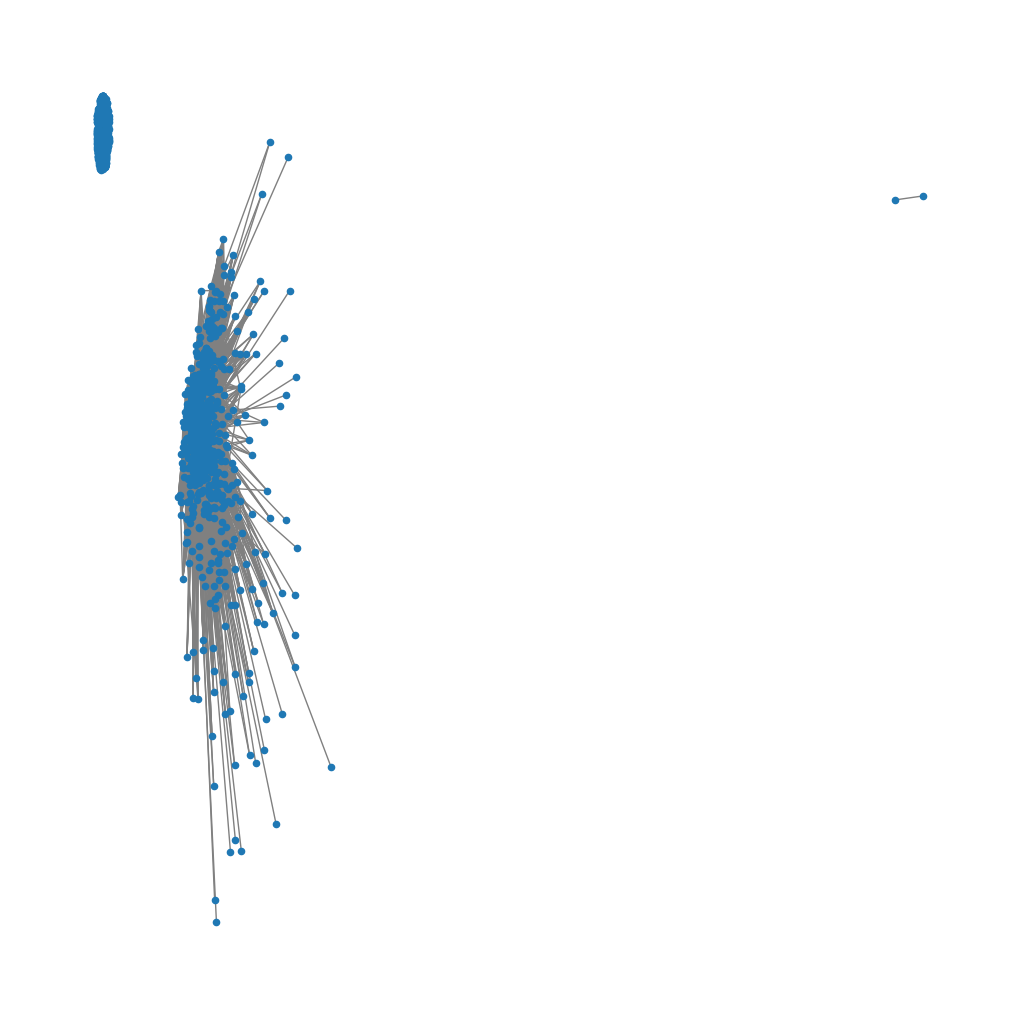

In [75]:
nx.draw(strong_G, node_size=20, edge_color='gray')

In [74]:
g = InteractiveGraph(strong_G, node_size=2, edge_width=0.5,
                     node_labels=strong_G.nodes, node_label_offset=0.05,
                     node_label_fontdict=dict(size=20, fontweight='bold'))

Error in callback <function flush_figures at 0x0000022C110513A0> (for post_execute):


KeyboardInterrupt: 

In [72]:
!pip install netgraph
from netgraph import InteractiveGraph # pip install netgraph

     ---------------------------------------- 93.6/93.6 kB 2.7 MB/s eta 0:00:00
     ---------------------------------------- 66.6/66.6 kB 3.8 MB/s eta 0:00:00
     ---------------------------------------- 41.8/41.8 kB 2.0 MB/s eta 0:00:00


In [83]:
edges = raw_G.edges()

# Use a list comprehension to create the edges_to_kill list
edges_to_kill = [(n, nbr) for n, nbrs in edges for nbr, eattr in nbrs.items() if eattr['weight'] < min_wt]

AttributeError: 'spacy.tokens.doc.Doc' object has no attribute 'items'